# Full Linear Modeling

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go
from statsmodels.formula.api import ols
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [40]:
pca_x = ["../data/production/pca/x_median.pickle",
         "../data/production/pca/x_imputed_1.pickle",
         "../data/production/pca/x_imputed_2.pickle",
         "../data/production/pca/x_imputed_3.pickle",
         "../data/production/pca/x_imputed_4.pickle",
         "../data/production/pca/x_imputed_5.pickle"]
imputed = ["../data/production/Full_clean_imputed_1.csv",
            "../data/production/Full_clean_imputed_2.csv",
            "../data/production/Full_clean_imputed_3.csv",
            "../data/production/Full_clean_imputed_4.csv",
            "../data/production/Full_clean_imputed_5.csv"]
clean = "../data/processed/Full_clean.csv"
tourism_columns = ['ST.INT.ARVL',
                    'ST.INT.XPND.MP.ZS', 'ST.INT.XPND.CD',
                   'ST.INT.DPRT', 'ST.INT.RCPT.XP.ZS', 'ST.INT.RCPT.CD',
                   'Tourist Defecit', 'Tourism Net', 'Tourist Avg Net',
                   'Population Estimate', 'ST.INT.ARVL.PER.CAPITA',
                   'ST.INT.DPRT.PER.CAPITA']

In [41]:
imputations = [pd.read_csv(x).set_index(["Country Code", "Year"]) for x in imputed]
pca_x_arrays = [np.load(x, allow_pickle=True) for x in pca_x]
clean_df = pd.read_csv(clean).set_index(["Country Code", "Year"])
y_df = clean_df[tourism_columns]

## Process the Data

In [42]:
# scale the data
scaler = preprocessing.MinMaxScaler()
for df in imputations:
    df[:] = scaler.fit_transform(df[:])
y_df[:] = scaler.fit_transform(y_df[:])
clean_df[:] = scaler.fit_transform(clean_df[:]);

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



In [43]:
# Remove fake index columns
for df in imputations:
    if "Unnamed: 0" in df.columns:
        df.drop("Unnamed: 0", axis="columns", inplace=True)
if "Unnamed: 0" in clean_df.columns:
        clean_df.drop("Unnamed: 0", axis="columns", inplace=True)

## Linear Regression

In [44]:
# Impute the missing values
imp = SimpleImputer(missing_values=np.nan, strategy='median')
median_imputed = clean_df.copy()
median_imputed[:] = imp.fit_transform(clean_df.values)

In [45]:
# Create lists of x and y columns
x = median_imputed.drop(tourism_columns,axis="columns").columns.values.tolist()
y_list = y_df.columns

In [46]:
ols_scores = {}
for y in y_list:
    scores = []
    for dataset in imputations:
        msk = np.random.rand(len(dataset)) < 0.8
        train = dataset[msk]
        test = dataset[~msk]
        res = LinearRegression()
        res.fit(train.drop(tourism_columns,axis="columns"),train[y])
        scores.append(res.score(test.drop(tourism_columns,axis="columns"),test[y]))
    res = LinearRegression()
    res.fit(median_imputed.drop(tourism_columns,axis="columns"),median_imputed[y])
    scores.append(res.score(median_imputed.drop(tourism_columns,axis="columns"),median_imputed[y]))
    for x_array in pca_x_arrays:
        msk = np.random.rand(len(dataset)) < 0.8
        train = x_array[msk]
        train_y = median_imputed[msk][y]
        test = x_array[~msk]
        test_y = median_imputed[~msk][y]
        res = LinearRegression()
        res.fit(train,train_y)
        scores.append(res.score(test,test_y))
    ols_scores[y] = max(scores)

In [47]:
ols_scores

{'ST.INT.ARVL': 0.6915444111988732,
 'ST.INT.XPND.MP.ZS': 0.27855550121343553,
 'ST.INT.XPND.CD': 0.8285950019179052,
 'ST.INT.DPRT': 0.607003361558259,
 'ST.INT.RCPT.XP.ZS': 0.39967532054032395,
 'ST.INT.RCPT.CD': 0.8728098955750141,
 'Tourist Defecit': 0.1827105176340796,
 'Tourism Net': 0.23483284977597307,
 'Tourist Avg Net': 0.3423405175008387,
 'Population Estimate': 0.5207214899632377,
 'ST.INT.ARVL.PER.CAPITA': 0.40817139226053767,
 'ST.INT.DPRT.PER.CAPITA': 0.3624594993732485}

### Y Selection
#### $R^2$ without PCA
{'ST.INT.ARVL': 0.675852391062048,

 'ST.INT.XPND.MP.ZS': 0.21200341745156914,
 
 'ST.INT.XPND.CD': 0.8412919537938548,
 
 'ST.INT.DPRT': 0.6113813727042621,
 
 'ST.INT.RCPT.XP.ZS': 0.3644287678690312,
 
 'ST.INT.RCPT.CD': 0.8535041218396786,
 
 'Tourist Defecit': 0.13105893926103807,
 
 'Tourism Net': 0.24427317525706657,
 
 'Tourist Avg Net': 0.34475616068936765,
 
 'Population Estimate': 0.636766087835353,
 
 'ST.INT.ARVL.PER.CAPITA': 0.46876625238076747,
 
 'ST.INT.DPRT.PER.CAPITA': 0.3624594993732483}
 
#### $R^2$ With PCA
{'ST.INT.ARVL': 0.6856360885037339,

 'ST.INT.XPND.MP.ZS': 0.23129413567801616,
 
 'ST.INT.XPND.CD': 0.8275349772305574,
 
 'ST.INT.DPRT': 0.5836403128964276,
 
 'ST.INT.RCPT.XP.ZS': 0.4014869884684903,
 
 'ST.INT.RCPT.CD': 0.8883785813247653,
 
 'Tourist Defecit': 0.1752872287880265,
 
 'Tourism Net': 0.23271929515733414,
 
 'Tourist Avg Net': 0.3562943380288015,
 
 'Population Estimate': 0.5736344237791429,
 
 'ST.INT.ARVL.PER.CAPITA': 0.4843666779553838,
 
 'ST.INT.DPRT.PER.CAPITA': 0.3624594993732483}

In [48]:
ols_models = {}
for y in y_list:
    top_score = 0
    top_model = 1
    xi = 0
    for dataset in imputations:
        msk = np.random.rand(len(dataset)) < 0.8
        train = dataset[msk]
        test = dataset[~msk]
        res = LinearRegression()
        res.fit(train.drop(tourism_columns,axis="columns"),train[y])
        score = res.score(test.drop(tourism_columns,axis="columns"),test[y])
        if score > top_score:
            top_score = score
            top_model = "imputation {}".format(xi)
        xi += 1
    res = LinearRegression()
    res.fit(median_imputed.drop(tourism_columns,axis="columns"),median_imputed[y])
    score = res.score(median_imputed.drop(tourism_columns,axis="columns"),median_imputed[y])
    if score > top_score:
            top_score = score
            top_model = "median"
    for i in range(len(pca_x_arrays)):
        x_array = pca_x_arrays[i]
        msk = np.random.rand(len(dataset)) < 0.8
        train = x_array[msk]
        train_y = median_imputed[msk][y]
        test = x_array[~msk]
        test_y = median_imputed[~msk][y]
        res = LinearRegression()
        res.fit(train,train_y)
        score = res.score(test,test_y)
        if score > top_score:
            top_score = score
            top_model = "pca {}".format(i)
    ols_models[y] = top_model
    print(top_score, top_model)

0.6960770171608015 imputation 0
0.2430198985529709 imputation 3
0.8605749797563911 imputation 4
0.6452270390485171 imputation 1
0.35223732228673055 imputation 1
0.8586035321374258 imputation 0
0.16434206998085688 imputation 3
0.22654165584377273 imputation 3
0.37669905518033403 imputation 4
0.6233839333985278 imputation 0
0.38167376802973163 median
0.4505311894341459 pca 0


In [49]:
ols_models

{'ST.INT.ARVL': 'imputation 0',
 'ST.INT.XPND.MP.ZS': 'imputation 3',
 'ST.INT.XPND.CD': 'imputation 4',
 'ST.INT.DPRT': 'imputation 1',
 'ST.INT.RCPT.XP.ZS': 'imputation 1',
 'ST.INT.RCPT.CD': 'imputation 0',
 'Tourist Defecit': 'imputation 3',
 'Tourism Net': 'imputation 3',
 'Tourist Avg Net': 'imputation 4',
 'Population Estimate': 'imputation 0',
 'ST.INT.ARVL.PER.CAPITA': 'median',
 'ST.INT.DPRT.PER.CAPITA': 'pca 0'}

In [50]:
def lin_model(dataset, y):
    msk = np.random.rand(len(dataset)) < 0.8
    train = dataset[msk]
    test = dataset[~msk]
    res = LinearRegression()
    res.fit(train.drop(tourism_columns,axis="columns"),train[y])
    score = res.score(test.drop(tourism_columns,axis="columns"),test[y])
    y_hat = res.predict(test.drop(tourism_columns,axis="columns"))
    y_actual = test[y]
    print(score)
    g = sns.scatterplot(y_actual, y_hat)
    plt.plot([1, 0], [1, 0], linewidth=1,color="red")
    g.set_xlabel("Expected Y")
    g.set_ylabel("Actual Y")
    g.set_title('ST.INT.XPND.CD Multiple Linear Regression');
    plt.show()
    g = sns.scatterplot(y_actual, y_actual-y_hat)
    plt.plot([1, 0], [0, 0], linewidth=1,color="red")
    g.set_ylabel("Residual Y")
    g.set_xlabel("Actual Y")
    g.set_title('ST.INT.XPND.CD Multiple Linear Regression');
def lin_model_np(dataset, y):
    msk = np.random.rand(len(dataset)) < 0.8
    train = dataset[msk]
    test = dataset[~msk]
    train_y = y[msk]
    test_y = y[~msk]
    res = LinearRegression()
    res.fit(train,train_y)
    score = res.score(test,test_y)
    y_hat = res.predict(test)
    y_actual = test_y
    print(score)
    g = sns.scatterplot(y_actual, y_hat)
    plt.plot([1, 0], [1, 0], linewidth=1,color="red")
    g.set_xlabel("Expected Y")
    g.set_ylabel("Actual Y")
    g.set_title('Multiple Linear Regression');
    plt.show()
    g = sns.scatterplot(y_actual, y_actual-y_hat)
    plt.plot([1, 0], [0, 0], linewidth=1,color="red")
    g.set_ylabel("Residual Y")
    g.set_xlabel("Actual Y")
    g.set_title('Multiple Linear Regression');

0.8350056147912983


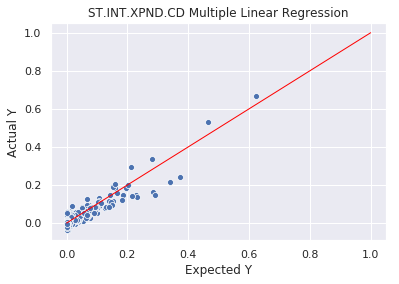

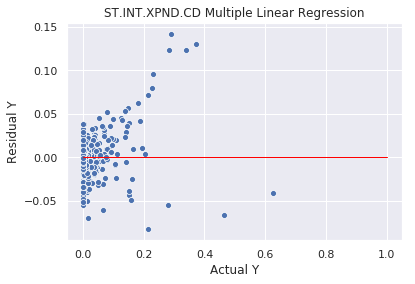

In [51]:
lin_model(imputations[0],'ST.INT.XPND.CD')

0.6825994623280238


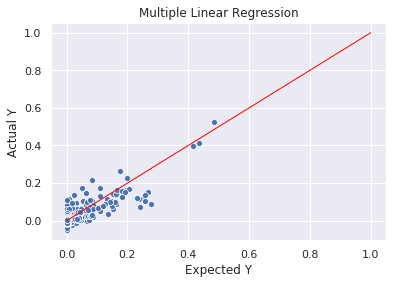

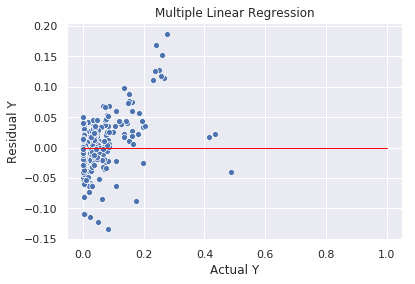

In [52]:
lin_model_np(pca_x_arrays[4],median_imputed['ST.INT.RCPT.CD'])

## Regression With Tensorflow

In [53]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Y]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Y^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('')
    print('.', end='')

In [54]:
def train_test(df):
    msk = np.random.rand(len(df)) < 0.8
    train = df[msk]
    test = df[~msk]
    return train, test

In [55]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation=tf.nn.relu, input_shape=[len(x)]),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.sigmoid),
    layers.Dense(32, activation=tf.sigmoid),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.

..................

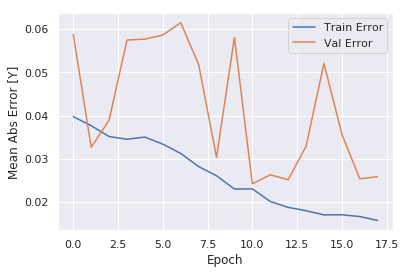

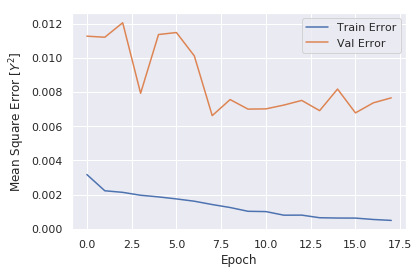

In [20]:
model = build_model()

train, test = train_test(median_imputed)
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train[x], train['ST.INT.RCPT.CD'], epochs=1000,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [21]:
loss, mae, mse = model.evaluate(test[x], test['ST.INT.RCPT.CD'], verbose=0)
print("Testing set Mean Abs Error: {:5.3f}".format(mae))

Testing set Mean Abs Error: 0.012


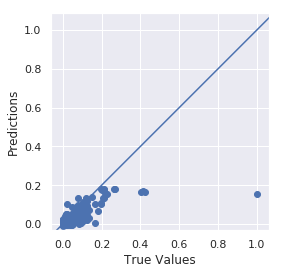

In [22]:
test_predictions = model.predict(test[x]).flatten()
plt.scatter(test['ST.INT.RCPT.CD'], test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100, 100], [-100, 100])

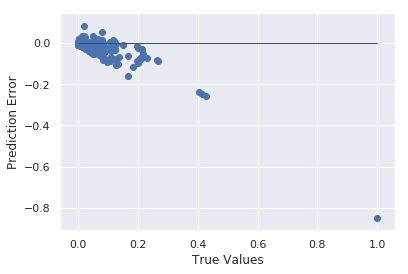

In [23]:
error = test_predictions - test['ST.INT.RCPT.CD']
plt.scatter(test['ST.INT.RCPT.CD'], error)
plt.xlabel('True Values')
plt.ylabel('Prediction Error')
plt.plot([1, 0], [0, 0], linewidth=1,color="red");


.........................
.....

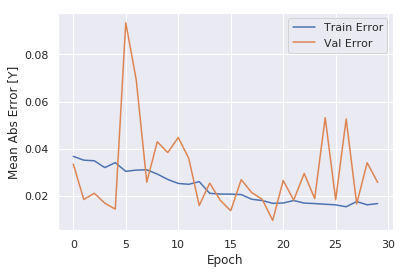

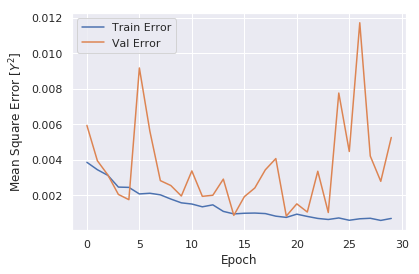

In [24]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train[x], train['ST.INT.XPND.CD'], epochs=1000,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [26]:
loss, mae, mse = model.evaluate(test[x], test['ST.INT.XPND.CD'], verbose=0)
print("Testing set Mean Abs Error: {:5.3f}".format(mae))

Testing set Mean Abs Error: 0.015


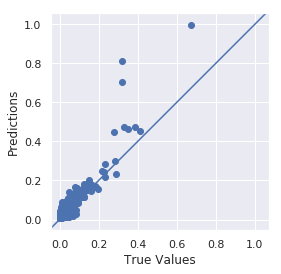

In [27]:
test_predictions = model.predict(test[x]).flatten()
plt.scatter(test['ST.INT.XPND.CD'], test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

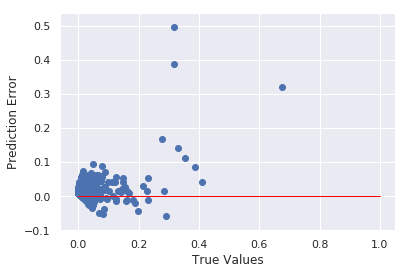

In [28]:
error = test_predictions - test['ST.INT.XPND.CD']
plt.scatter(test['ST.INT.XPND.CD'], error)
plt.xlabel('True Values')
plt.ylabel('Prediction Error')
plt.plot([1, 0], [0, 0], linewidth=1,color="red");